In [1]:
%matplotlib inline
import numpy as np
import scipy.signal as signal    # Notice this one is new!
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from mpl_toolkits.mplot3d import Axes3D
import math
import cmath
from scipy import interpolate 
from scipy.spatial import distance 
from copy import deepcopy

In [2]:

def Import(photo):
    img = plt.imread(photo)
    #plt.figure()
    
    #plt.imshow(img)
    return img

#turn image into array 
def NotGray(thresh, image):
    imarray = np.array(image)
    if len(imarray[0][0]) == 4:
        return "you put in a RBGA image"
    #makeit truely black and white:
    else:
        for i in range(len(imarray)):
            for j in range(len(imarray[0])):
                #print(imarray[0][0])
                for k in range(3):
                    #thresh = 200             #by raising this will pick up more grey values included
                                            #will be darker/more continuous but also more noisy- this might becom param of eqn.
                    if imarray[i][j][k] < thresh:
                        imarray[i][j][k]=0     #0 is what 'black' is for python color codes
                    else: imarray[i][j][k]=255 #255 is 'white' 
    return imarray
#this will show the pure black and white image
                            #These following lines are just to check that now each triplet have the same values(it comes from the RGB plt.imread)
                            #for i in range(len(imarray)):            
                            #    for j in range(len(imarray[0])):
                            #        for k in range(len(imarray[0][0])):
                            #             if imarray[i][j][k] != imarray[i][j][0]:
                            #                print(imarray[i][j])
def CollapseRBG(array):  #array is NxMx3
    bwimarray = np.zeros([len(array), len(array[0])])  #Here I am turning my RBG array into a BW array (Collapsing third dim)
    for i in range(len(array)):
        for j in range(len(array[0])):
            bwimarray[i][j] = array[i][j][0]    #Setting each element the array to the last elemet of the triplet since they are all the same.      
    return bwimarray                                        #This might be kinda messed up if the photo you upload isnt black and white. But it shouldent be too messed up

def FinalSize(array):
    fin_x_dim = len(array)
    fin_y_dim = len(array[0])
    return fin_x_dim, fin_y_dim
    
def black_coords(array):
    black = np.where(array==0)
    b = np.zeros([len(black[0]),2])
    #print(len(black[0]))
    for i in range(len(black[0])):
        coord = np.array([black[0][i], black[1][i]])
        b[i] = coord
    return b

def PairCoord_Index(start, coordslist): 
    """
    start needs to be an np.array([x,y]) where [x,y] in coordlist
    and x, y are floats
    this is going to be finicky 
    """
    pair_dict = dict()
    start_str = str(start)
    for i in enumerate(coordslist):
        coord_str = str(i[1])
        #print(coord_str)
        pair_dict[coord_str] = i[0]
    return pair_dict[start_str]


###distance between each black coord with another
def Distance(coord_list):
    distance_matrix = distance.cdist(coord_list, coord_list)
    return distance_matrix


#having checked this with rainbows, it honestly workes as expected. a little slow for a 440 KB photo, rel fast for 140 KB
#for rainbow picture with lower thresh, will be difference in bwimarray with what is plotted(choosing R, B or G)
#I think just always put a reg picture in that happens to only be greyscale. 



In [230]:
def BestPath(start, array):
    """
    Start in form np.array([x., y.])
    """
    coordinates = black_coords(array)
    #print(len(coordinates))
    matrix = Distance(coordinates)
    sp = PairCoord_Index(start, coordinates)
    path_coord_x = [coordinates[sp][0]]
    path_coord_y = [coordinates[sp][1]]
    #print(sp)
    path_index = [sp]
    #print('len(coordinates)')
    #print(len(coordinates))
    for i in range(len(coordinates)):
        row = matrix[sp,:]
        for j in path_index:
            row[j] = np.infty
        closest = np.argmin(row)
        #print('for i=', i, 'closest =', closest)
        path_coord_x.append(coordinates[closest][0])
        path_coord_y.append(coordinates[closest][1])
        path_index.append(closest)
        sp = closest
    path_coord_x.append(path_coord_x[0])
    path_coord_y.append(path_coord_y[0])
    path_index.append(path_index[0])
    print(len(path_coord_x))
    return path_coord_x, path_coord_y
    


In [30]:
from scipy.interpolate import UnivariateSpline
##Going to make line approximation; using UnivariateSpline 
##Splines are linear approximations to a line. 

def lineapprox(path_x, path_y, plot=True, num_evals=1000):
    arange = np.arange(0, len(path_x),1)
    path_x_array = np.array(path_x)
    path_y_array = np.array(path_y)
    flip_y = -1*path_y_array
    x_approx = UnivariateSpline(arange, path_x_array)
    y_approx = UnivariateSpline(arange, path_y_array)
    #print(type(x_approx))
    # print(x_approx.size)
    x_approx_array = [0] * num_evals
    y_approx_array = [0] * num_evals
    index = 0
    for v in (np.linspace(0, len(path_x)-1, num_evals)):
        #print('type in here: ', type(x_approx(v)))
        #print('this item: ', x_approx(v))
        x_approx_array[index] = float(x_approx(v))
        y_approx_array[index] = float(y_approx(v))
        index += 1
    #print(x_approx_array)
    #print(y_approx_array)
    t = np.linspace(0, len(path_x), num_evals)
    endpoint_x = np.mean([x_approx_array[0], x_approx_array[-1]])
    x_approx_array[0] = endpoint_x
    x_approx_array[-1] = endpoint_x
    x_approx_array = x_approx_array - x_approx_array[0]                      
          
    endpoint_y = np.mean([y_approx_array[0], y_approx_array[-1]])
    y_approx_array[0] = endpoint_y
    y_approx_array[-1] = endpoint_y
    y_approx_array = y_approx_array - y_approx_array[0]
    
    if plot == True:
        #plt.plot(x,y, 'k')
        #plt.plot(*zip(*[(x_approx(v), y_approx(v)) for v in np.linspace(0, len(path_x)-1, 1000)]))
        plt.plot(x_approx_array, y_approx_array)
        plt.axis('equal')
        #plt.gca().invert_xaxis()
        #plt.gca().invert_yaxis()
        #plt.plot(splines)
        #plt.plot(arange, x_approx)
        #pltl.plot(arange, y_approx)
    return x_approx_array, y_approx_array,t


In [5]:
def cn(f, t, n):
    ##t needs to be from 0 to T interval. 
    T = t[-1]
    delta_t = T/len(t)
    
    integrand = (1/T)*f*np.exp(-1j*2*np.pi*n*t/T)
    integral =(sum(integrand))*delta_t
    
    return integral
#outputs COMPLEX NUMBER



In [6]:
def f_one_x_one_n(f, t, n, cn, x):
    T = t[-1]
    term = cn*np.exp(1j*2*np.pi*n*x/T)
    return term


def fft_at_t(f,t,x, N, c): #Please o Please let N be even
    f_of_t = 0
    #print('x=', x)
    #c is an array 
    count_from_0 = 0
    for i in range(-N//2,N//2+1):
        c_i =c[count_from_0]
        
        additional_term =f_one_x_one_n(f,t,i,c_i,x)
        f_of_t += additional_term
        #print(i,'th term of f=', np.round(additional_term, decimals= 3))
        count_from_0 += 1
    return f_of_t  


In [7]:
def F_all_t(f, t, N):
    FT_of_f = np.zeros(len(t))
    c = np.zeros(N+1, dtype = np.complex_)
    count = -N//2
    for j in range(N+1):        
        c[j] = cn(f,t,count)  ##c will be the set of coefficients evaluated at -N//2 to N//2+1
        count += 1            ### we will only be calculating c once.
        
    for i in range(len(t)):
        FT_of_f[i] = np.round(fft_at_t(f, t, t[i], N, c).real)    #This is takes imout of c as an array
    return FT_of_f

def PutInPlace(x_vals, y_vals, bw_array):  
    black_coords_real = np.where(bw_array == 0)
    black_real_x = black_coords_real[0]
    black_real_y = black_coords_real[1]
    x_real_min = min(black_real_x)
    y_real_min = min(black_real_y)
    

    x_fft_min = min(x_vals)
    y_fft_min = min(y_vals)
    if x_fft_min != x_real_min:
        x_vals = x_vals + (x_real_min - x_fft_min)
    return x_vals, y_vals

#fft_test = F_all_t(f_test, t_test, 2)
#plt.plot(t_test, fft_test, 'k')




In [27]:
from PIL import Image

def SavePlot(x_vals, y_vals, outputname):
    plt.figure(figsize=(15,15))
    plt.axis('equal')
    plt.plot(x_vals, y_vals, 'k-', linewidth =5)
    plt.axis('off')
    
    #axes.get_xaxis().set_visible(False)
    #axes.get_yaxis().set_visible(False)
    plt.savefig(outputname, dpi=95,pad_inches=0)
    plt.close()
    
def NotGrey01(array):  #array should be NxM converted from png
    for i in range(len(array)):
        for j in range(len(array[0])):
            if 0 <= array[i][j]<=.25:
                array[i][j] = 0
            else:
                array[i][j] =255
    return array   
    


In [231]:
def SetUpPicture(file_name, thresh_ng=200, start=0, PlotParam=False, evals_line_approx=1000, Save=False, save_plot_as='generic_name', IImport=False, plot_import=False, debug= False ):
    
    image = Import(file_name)
    if debug== True: 
        print('import done')
    image_ng = NotGray(thresh_ng, image)  #dtype array
    if debug== True: 
        print('not_grey done')
    image_bw = CollapseRBG(image_ng)
    if debug== True: 
        print('collapseRBG done')
    blk_coords = black_coords(image_bw)
    if debug== True: 
        print('black_coords found')
    path_through_black = BestPath(blk_coords[start], image_bw)
    if debug== True: 
        print('path found')
    splines = lineapprox(path_through_black[0], path_through_black[1], plot=PlotParam, num_evals= evals_line_approx)
    if debug== True: 
        print('lineapprox done')
    xt = splines[0]
    yt = splines[1]
    t = splines[2]
    if Save == True:
        SavePlot(xt, yt, save_plot_as)
        if debug== True: 
            print('saveplot done')
        if IImport == True:
            imported_img = Import(save_plot_as+'.png')
            if debug == True: 
                print('import done')
            imported_array = np.array(imported_img)
            imported_bw = CollapseRBG(imported_array)
            if debug== True: 
                print('imported collapse RBGA done')
            imported_255 = NotGrey01(imported_bw)
            if debug== True: 
                print('NotGrey01 done')
            if plot_import == True:
                plt.imshow(imported_255)
            return xt, yt, t, imported_255
    else: return xt, yt, t, 'no import here'

In [33]:
def PreformFourier(xt, yt, t, N, Plot_fft=False, Save=False, save_plot_as='generic_approx', IImport=False,plot_import=False, debug=False):
    fft_x = F_all_t(xt, t, N)
    fft_y = F_all_t(yt, t, N)
    if debug== True: 
        print("fft's done")
    if Plot_fft == True:
        plt.plot(fft_x,fft_y)
    if Save == True:
        SavePlot(fft_x, fft_y, save_plot_as)
        if debug== True: 
            print('SavePlot done')
        if IImport == True:
            imported_img = Import(save_plot_as+'.png')
            if debug== True: 
                print('import done')
            imported_array = np.array(imported_img)
            imported_bw = CollapseRBG(imported_array)
            if debug== True: 
                print('collapse RBGA done')
            imported_255 = NotGrey01(imported_bw)
            if debug== True: 
                print('NotGrey01 done')
            if plot_import == True:
                plt.imshow(imported_255)
            return imported_255
    else: return 'no imported image'


In [71]:
def JustImport(save_plot_as, IImport =False, plot_import=False, debug =False):
    imported_img = Import(save_plot_as+'.png')
    if debug == True: 
        print('import done')
    imported_array = np.array(imported_img)
    imported_bw = CollapseRBG(imported_array)
    if debug== True: 
        print('imported collapse RBGA done')
    imported_255 = NotGrey01(imported_bw)
    if debug== True: 
        print('NotGrey01 done')
    if plot_import == True:
        plt.imshow(imported_255)
    return imported_255

In [15]:
def ImageDetector(TrueImage, GeneratedImage):
    """
    True image and Generated Image should be arrays of the same dimension
    """
    TI = TrueImage
    GI = GeneratedImage
    num_same= 0
    for i in range(len(TI)):
        for j in range(len(TI[0])):
            if TI[i][j] == GI[i][j]:
                num_same += 1
    num_pix= len(TI)*len(TI[0])
    return num_same/num_pix

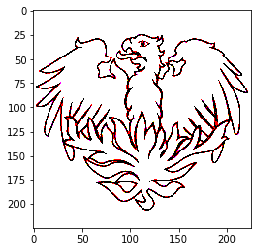

In [294]:
pheonix= Import('pheonix.jpg')
#plt.imshow(pheonix)
pheonix_array = np.array(pheonix)
pheonix_ng = NotGray(120, pheonix)
plt.imshow(pheonix_ng)


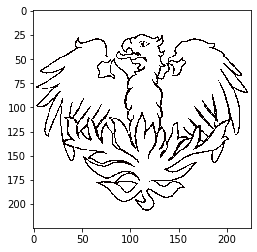

In [295]:
pheonix_bw = CollapseRBG(pheonix_ng)
black_coords_pheonix = black_coords(pheonix_bw)
plt.imshow(pheonix_bw)
#calvin_path =BestPath(black_coords_calvin[0], calvin_bw)

import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


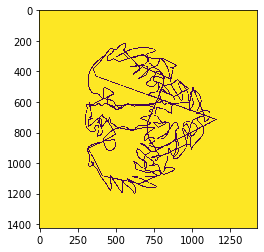

In [97]:
pheonix_x, pheonix_y, pheonix_t, pheonix_param = SetUpPicture('pheonix.jpg', start=3000, thresh_ng=120, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='phil_param', IImport=True, plot_import=True, debug= True)

import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


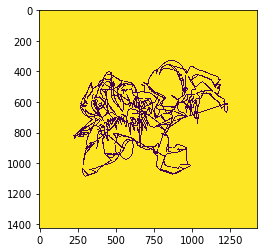

In [18]:
napoleon_x, napoleon_y, napoleon_t, napoleon_param = SetUpPicture('napoleon_rbg.jpg', start=-1, PlotParam=True, evals_line_approx=1000, Save=True, save_plot_as='napoleon_param', IImport=True, plot_import=True, debug= True)

In [19]:
N_vals_1 = np.arange(2, 633, 10) 
N_vals_3 = np.arange(730, 1231, 10)
N_vals_4 = np.arange(640, 730, 10)



In [50]:
#N_vals_1 = np.arange(2, 633, 10) 
#N_vals_2 = np.arange(30, 631, 100)
#N_vals = np.concatenate((N_vals_1, N_vals_2))
#N_vals_3 = np.arange(630, 1230, 100)
#napoleon_big_array = []
#for n in N_vals_1:
#    name = 'napoleon' + str(n)
#    list_n = PreformFourier(napoleon_x, napoleon_y, napoleon_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    napoleon_big_array.append(list_n)
    #print(n, 'is done')
#print(napoleon_big_array)

In [51]:
##N_vals_3 = np.arange(730, 1231, 10)
#napoleon_big_array_3 = []
#for n in N_vals_3:
#    name = 'napoleon' + str(n)
##    list_n = PreformFourier(napoleon_x, napoleon_y, napoleon_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    napoleon_big_array_3.append(list_n)
#    print(n, 'is done')


In [52]:
#N_vals_4 = np.arange(640, 730, 10)
##napoleon_big_array_4 = []
#for n in N_vals_4:
#    name = 'napoleon' + str(n)
#    list_n = PreformFourier(napoleon_x, napoleon_y, napoleon_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    napoleon_big_array_4.append(list_n)
#    print(n, 'is done')

In [53]:
#napoleon_to_1230 = np.concatenate((napoleon_big_array, napoleon_big_array_3))
#napoleon_to_1230 = np.concatenate((napoleon_to_1230, napoleon_big_array_4))
#print(len(napoleon_to_1230))

In [364]:
#precent_sim = np.zeros([len(napoleon_to_1230)])
#for i in range(len(napoleon_to_1230)):
#    pre = ImageDetector(napoleon_param, napoleon_to_1230[i])
 #   precent_sim[i] = pre
    #print(i, 'is done')



NameError: name 'N_vals_1' is not defined

In [54]:
#plt.imshow(napoleon_to_1230[-4])

In [55]:
#plt.imshow(napoleon_param)

In [56]:
#ImageDetector(napoleon_param, napoleon_to_1230[-4])

In [98]:
N_to_1600 = np.concatenate((np.arange(2,633,10), np.arange(640, 1601, 10)))

N_to_1230 = np.concatenate((np.arange(2,633,10), np.arange(640, 1231, 10)))


import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


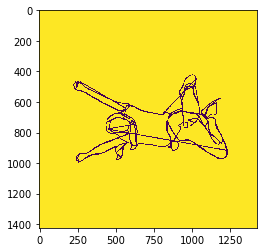

In [58]:
girl_x, girl_y, girl_t, girl_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='girl_param', IImport=True, plot_import=True, debug= True)

In [99]:
girl_big_array = []
for n in N_to_1230:
    name = 'girl' + str(n)
    list_n = JustImport(save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_big_array.append(list_n)

In [100]:
girl_precent_sim = np.zeros([len(N_to_1230)])
for i in range(len(N_to_1230)):
    pre = ImageDetector(girl_param, girl_big_array[i])
    girl_precent_sim[i] = pre
    #print(i, 'is done')

In [183]:
girl_255 = np.full((np.shape(girl_param)),255)
print(np.shape(girl))

precent_sim_255 = ImageDetector(girl_param, girl_255)
print(precent_sim_255)


(1425, 1425)
0.9665014465989535


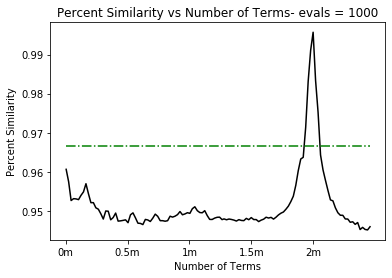

In [394]:
plt.plot(N_to_1230, girl_precent_sim, 'k-')
#plt.suptitle('Girl')
plt.title('Percent Similarity vs Number of Terms- evals = 1000')
plt.xlabel('Number of Terms')
plt.ylabel('Percent Similarity')
plt.plot((0,1230), (precent_sim_255,precent_sim_255), 'g-.')
#plt.plot(N_to_1230, precent_sim, 'r.')
plt.xticks(np.arange(0, 1231,250 ), ('0m', '0.5m','1m', '1.5m', '2m', '2.5m'))
plt.savefig('girl_plot', dpi=95,pad_inches=.1)



import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


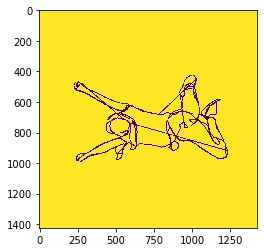

In [83]:
girl_x_500, girl_y_500, girl_t_500, girl_param_500 = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=500, Save=True, save_plot_as='girl_param_500', IImport=True, plot_import=True, debug= True)

In [63]:
#N_1240_to_1600 = np.arange(1240, 1601,10)
#for n in N_1240_to_1600:
#    name = 'girl_500_' + str(n)
#    list_n = PreformFourier(girl_x_500, girl_y_500, girl_t_500,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    girl_big_array_500.append(list_n)
#    print(n, 'is done')

In [78]:
girl_big_array_500 = []
for n in N_to_1600:
    name = 'girl_500_' + str(n)
    list_n = JustImport(save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_big_array_500.append(list_n)
    

In [84]:
girl_500_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(girl_param_500, girl_big_array_500[i])
    girl_500_precent_sim[i] = pre

In [188]:
precent_sim_255_500 = ImageDetector(girl_param_500, girl_255)


([<matplotlib.axis.XTick at 0x17cb6317198>,
 <a list of 7 Text xticklabel objects>)

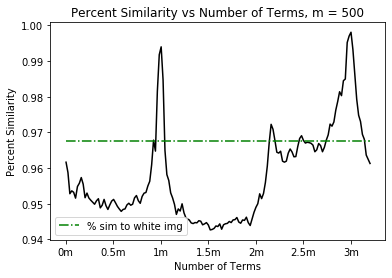

In [299]:
plt.plot(N_to_1600, girl_500_precent_sim, 'k-')
plt.plot((0,1600), (precent_sim_255_500,precent_sim_255_500), 'g-.', label='% sim to white img')
#plt.suptitle('Girl')
plt.title('Percent Similarity vs Number of Terms, m = 500')
plt.xlabel('Number of Terms')
plt.ylabel('Percent Similarity')
plt.legend(loc='lower left')
plt.savefig('girl_500_plot', dpi=95,pad_inches=.1)
plt.xticks(np.arange(0, 1501,250 ), ('0m', '0.5m','1m', '1.5m', '2m', '2.5m',  '3m'))

import done
not_grey done
collapseRBG done
black_coords found
6400
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


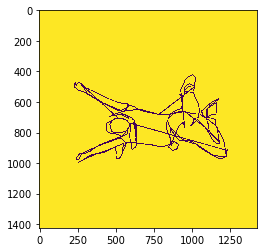

In [232]:
girl_x_250, girl_y_250, girl_t_250, girl_250_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=250, Save=True, save_plot_as='girl_250_param', IImport=True, plot_import=True, debug= True)

In [107]:
girl_array_250 = []
for n in N_to_1600:
    name = 'girl_250_' + str(n)
    list_n =PreformFourier(girl_x_250, girl_y_250, girl_t_250,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_array_250.append(list_n)

In [160]:
N_1600_to_1900 = np.arange(1610, 1901, 10)

In [161]:
girl_array_250_addon = []
for n in N_1600_to_1900:
    name = 'girl_250_' + str(n)
    list_n =PreformFourier(girl_x_250, girl_y_250, girl_t_250,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_array_250_addon.append(list_n)

In [267]:
list_250_250 =PreformFourier(girl_x_250, girl_y_250, girl_t_250,250,Save=True, save_plot_as='girl_250_250', IImport=True,plot_import=False, debug=False)

In [276]:
Need = [125, 375,500,625,750,875,1000,1125,1250,1375,1500,1625,1750,1875]
girl_250_Need=[]
for n in Need:
    name = 'girl_250_' + str(n)
    list_n =PreformFourier(girl_x_250, girl_y_250, girl_t_250,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_250_Need.append(list_n)

In [268]:
girl_250__250_precent_sim = ImageDetector(girl_250_param, list_250_250)

In [278]:
girl_250_precent_sim_Need = np.zeros([len(Need)])
for i in range(len(Need)):
    pre = ImageDetector(girl_250_param, girl_250_Need[i])
    girl_250_precent_sim_Need[i] = pre

In [162]:
girl_250_precent_sim_addon = np.zeros([len(N_1600_to_1900)])
for i in range(len(N_1600_to_1900)):
    pre = ImageDetector(girl_250_param, girl_array_250_addon[i])
    girl_250_precent_sim_addon[i] = pre


In [140]:
##Girl 250 finding percent similarity
girl_250_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(girl_250_param, girl_array_250[i])
    girl_250_precent_sim[i] = pre

In [165]:
girl_250_precent_sim_1900 = np.concatenate((girl_250_precent_sim, girl_250_precent_sim_addon))
N_vals_1900 = np.concatenate((N_to_1600, N_1600_to_1900))

In [193]:
precent_sim_255_250 = ImageDetector(girl_250_param, girl_255)

([<matplotlib.axis.XTick at 0x17c83e26c50>,
 <a list of 16 Text xticklabel objects>)

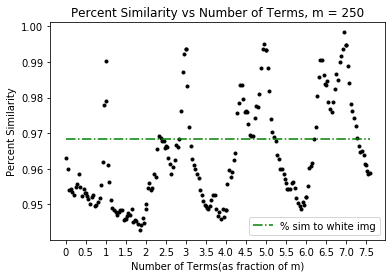

In [379]:
plt.plot(N_vals_1900, girl_250_precent_sim_1900, 'k.')
plt.plot((0,1900), (precent_sim_255_250,precent_sim_255_250), 'g-.',label='% sim to white img')
plt.plot(250,girl_250__250_precent_sim, 'k.')
plt.plot(Need, girl_250_precent_sim_Need, 'k.')
plt.title('Percent Similarity vs Number of Terms, m = 250')
plt.xlabel('Number of Terms(as fraction of m)')
plt.ylabel('Percent Similarity')
plt.legend(loc='lower right')
#plt.savefig('girl_250_plot', dpi=95,pad_inches=.1)
plt.xticks(np.arange(0, 1901,125 ), ('0', '0.5','1', '1.5', '2', '2.5',  '3', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5'))

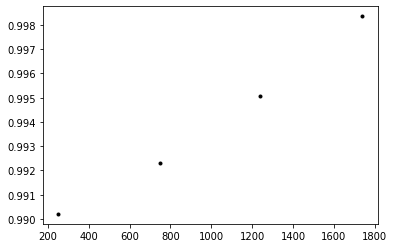

In [390]:
x_vals = (250, 750, 1240, 1740)
precent =girl_250_precent_sim_1900
numbers = N_vals_1900
five = np.where(numbers==582)[0][0]
seven = np.where(numbers==740)[0][0]
ten = np.where(numbers==1090)[0][0]
twelve = np.where(numbers==1240)[0][0]
fifteen = np.where(numbers==1590)[0][0]
seventeen =np.where(numbers==1740)[0][0]
y_vals = (girl_250__250_precent_sim,  precent[seven],  precent[twelve], precent[seventeen])
plt.plot(x_vals, y_vals, 'k.')
dy = (.001, .001, .001, .001)

In [391]:
from scipy import optimize
def linear(p, xvar):                                           #This will define a generic linear function- I will keep this
    return p[0] + p[1]*xvar
def linear_residual(p, xvar, yvar, err):                       #This will be an imput for our least squares method
    return (linear(p, xvar) - yvar)/err
array = [1.,1.]
def LinearFit(guess, x, y, dy, title, axisx, axisy, B, output=False):
    guess = array
    pf, cov, info, mesg, success = optimize.leastsq(linear_residual, guess,
                                                args=(x, y, dy), full_output=1)
    print('one')
    # If the fit failed, print the reason
    if cov is None:
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
    else:
        print(len(pf))
        chisq = sum(info['fvec']*info['fvec'])
        dof = len(x) - len(pf)
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        epsilon = (pf[0]/pf[1])+1
        depsilon = (epsilon)*((pferr[0]/pf[0])**2 + (pferr[1]/pf[1])**2)**(.5)
        print('Converged with chi-squared', chisq)
        print('Number of degrees of freedom, dof =', dof)
        print('Reduced chi-squared ', chisq/dof)
        print('Inital guess values:')
        print('  p0 =', guess)
        print('Best fit values:')
        print('  pf =', pf)
        print('  epsilon =', epsilon)
        print('Uncertainties in the best fit values:')
        print('  pferr =', pferr)
        print('  depsilon =', depsilon) 
             
    fig = plt.figure()
   
    ax = fig.add_subplot(111)
    plt.setp(ax, xticks=np.arange(0, 1901,250 ), xticklabels=np.arange(0,7.6, 1))
    ax.errorbar(x, y, dy, fmt='ko', label = 'Data')
    X = np.linspace(x.min(), x.max(), 500)
    ax.plot(X, linear(pf, X), 'r-', label = 'Linear Fit')
    #ax.xticks(np.arange(0, 1901,125 ), ('0', '0.5','1', '1.5', '2', '2.5',  '3', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5'))
    ax.set_title(title)
    ax.set_xlabel(axisx)
    ax.set_ylabel(axisy)
    ax.legend(loc='lower right')
    
     # Here is the text we want to include...
    textfit = '$y = mx+b $\n' \
              '$b = %.2f \pm %.2f$ \n' \
              '$m = %.1e \pm %.0e$ \n' \
              '$\chi^2= %.1f$ \n' \
              '$N = %i$ (dof) \n' \
              '$\chi^2/N = % .2f$' \
               % (pf[0], pferr[0], pf[1], pferr[1],
               chisq, dof, chisq/dof)
    #... and below is where we actually place it on the plot
    ax.text(0.05, 0.95, textfit , transform=ax.transAxes, fontsize=12,
            verticalalignment='top')
    #textfit2 = '$m = % $\n' \
     #           % (B)
   # ax.text(.7, .05,  textfit2 ,transform=ax.transAxes, fontsize=12,
    #          verticalalignment='top')
    #ax.set_xlim([x.min()-50, x.max()+50])
       # plt.savefig('Example2_Figure1.pdf')
    plt.show()
    if output== True:
        return [pf, pferr]

one
2
Converged with chi-squared 0.3514096065094835
Number of degrees of freedom, dof = 2
Reduced chi-squared  0.17570480325474175
Inital guess values:
  p0 = [1.0, 1.0]
Best fit values:
  pf = [9.88532667e-01 5.48181454e-06]
  epsilon = 180330.4619712679
Uncertainties in the best fit values:
  pferr = [0.0010270504199038116, 9.016329203789486e-07]
  depsilon = 29660.821894376986


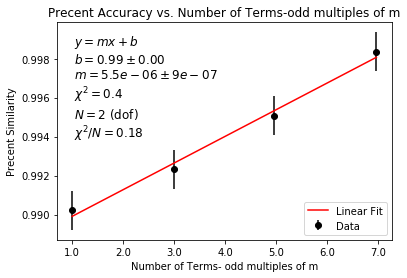

In [392]:

LinearFit(guess, np.array(x_vals), np.array(y_vals), np.array(dy), 'Precent Accuracy vs. Number of Terms-odd multiples of m', 'Number of Terms- odd multiples of m', 'Precent Similarity', 250, output=False)

In [274]:
#print(np.abs(fft_precent_sim[15:]))
where =np.where(girl_250_precent_sim_1900 >.97)
#for i in where[0]:
    #print(i)
    #print(N_vals_1900[i], girl_250_precent_sim_1900[i])
freq_vals = np.arange(0, 1901, 125)  


In [247]:
print(girl_250_precent_sim_1900[int(precent_sim_255_250])


0.9629114188981225


import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


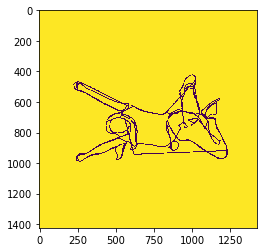

In [146]:
girl_x_750, girl_y_750, girl_t_750, girl_750_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=750, Save=True, save_plot_as='girl_750_param', IImport=True, plot_import=True, debug= True)

In [143]:
girl_array_750 = []
for n in N_to_1600:
    name = 'girl_750_' + str(n)
    list_n =PreformFourier(girl_x_750, girl_y_750, girl_t_750,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_array_750.append(list_n)

In [148]:
girl_750_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(girl_750_param, girl_array_750[i])
    girl_750_precent_sim[i] = pre

In [195]:
precent_sim_255_750 = ImageDetector(girl_750_param, girl_255)

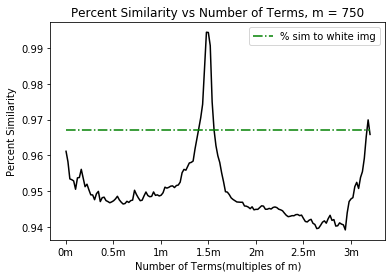

In [396]:
plt.plot(N_to_1600, girl_750_precent_sim, 'k-')
plt.plot((0,1600), (precent_sim_255_750,precent_sim_255_750), 'g-.',label='% sim to white img')
plt.title('Percent Similarity vs Number of Terms, m = 750')
#plt.suptitle('Girl')
plt.xlabel('Number of Terms(multiples of m)')
plt.ylabel('Percent Similarity')
plt.legend(loc = 'best')
plt.xticks(np.arange(0, 1501,250 ), ('0m', '0.5m','1m', '1.5m', '2m', '2.5m',  '3m'))
plt.savefig('girl_750_plot', dpi=95,pad_inches=.1)

In [86]:
N_to_1610 = np.arange(2, 1611, 10)

import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


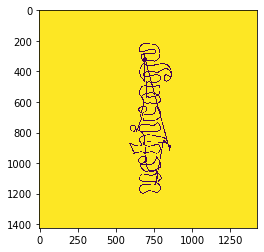

In [135]:
uc_x, uc_y, uc_t, uc_param = SetUpPicture('uchicago.jpg', start=-615, thresh_ng=200, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='uc_param', IImport=True, plot_import=True, debug= True)

In [110]:
uc_array_1000 = []
for n in N_to_1600:
    name = 'uc_1000_' + str(n)
    list_n =PreformFourier(uc_x, uc_y, uc_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    uc_array_1000.append(list_n)

In [136]:
##UCHICAGO finding percent similarity
uc_1000_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(uc_param, uc_array_1000[i])
    uc_1000_precent_sim[i] = pre
    

Text(0, 0.5, 'Percent Similarity')

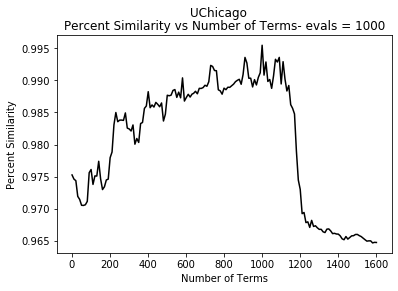

In [137]:
plt.plot(N_to_1600, uc_1000_precent_sim, 'k-')
plt.title('Percent Similarity vs Number of Terms- evals = 1000')
plt.suptitle('UChicago')
plt.xlabel('Number of Terms')
plt.ylabel('Percent Similarity')

In [ ]:
girl_x_250, girl_y_250, girl_t_250, girl_250_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=True, evals_line_approx=250, Save=True, save_plot_as='girl_param', IImport=True, plot_import=False, debug= True)

In [ ]:
uc_x, uc_y, uc_t, uc_param = SetUpPicture('uchicago.jpg', start=-615, thresh_ng=200, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='uc_param', IImport=True, plot_import=True, debug= True)

In [150]:
ImageDetector(girl_param, girl_250_param)

0.9758044936903663

In [152]:
ImageDetector(girl_param, girl_param_500)

0.9821188057863958

In [154]:
ImageDetector(girl_param, girl_750_param)

0.9861254539858418

In [155]:
ImageDetector(girl_param, girl_param)

1.0